# Homework Week 11, Heather Leighton-Dick

## 1.	What scale of measurement applies to timeseries data? Is timeseries data continuous or discrete? Why?

Timeseries data is quantitative and is measured on an interval scale with the same distance between data points. Timeseries data is continuous because the distances between data points can be divided into smaller increments.

## 2.	What does ARIMA stand for? Break down and explain each piece in the name.

ARIMA stands for Auto Regression Integration Moving Average. AR (autoregressive) is a model that uses input from previous steps in time for calculating present values and predicting future values. (Order of) Integration is a process used to make a series stationary (eliminates exponential . The Moving Average model smoothes out data over a particular time period by creating a constantly averaged value.

## 3.	Use the data in the temperatures/ folder and write a function that efficiently converts every column to a different temperature scale; one that is more common than Kelvin.

In [1]:
import numpy as np
import pandas as pd
import time
import math
import statistics
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
#from tqdm import tqdm_notebook
#from itertools import product
import warnings
warnings.filterwarnings('ignore')

#bring in csv and convert it to a dataframe
temperature_df = pd.read_csv("temperature.csv")
temperature_df = pd.DataFrame(temperature_df)
#print(temperature_df.head(5))
#print(temperature_df.tail(795))
#print(len(temperature_df))

#normalize date and time information, and split datetime column into date and time columns
#time of day is not relevant to avg in this case
temperature_df['Date'] = pd.to_datetime(temperature_df['datetime']).dt.strftime("%m/%d/%Y")
#df['Date'] = pd.to_datetime(df.Date, )
temperature_df['Time'] = pd.to_datetime(temperature_df['datetime']).dt.time
temperature_df["Date"] = temperature_df["Date"].apply(pd.to_datetime)
#df[["col1", "col2", "col3"]] = df[["col1", "col2", "col3"]].apply(pd.to_datetime)
#temperature_df["Date"].dt.strftime("%m/%d/%y")

#testing/exploring
#print(temperature_df["Seattle"])
print(temperature_df.info())
print(temperature_df.head())
#print(temperature_df.describe())
#print(temperature_df.index)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45253 entries, 0 to 45252
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   datetime           45253 non-null  object        
 1   Vancouver          44458 non-null  float64       
 2   Portland           45252 non-null  float64       
 3   San Francisco      44460 non-null  float64       
 4   Seattle            45250 non-null  float64       
 5   Los Angeles        45250 non-null  float64       
 6   San Diego          45252 non-null  float64       
 7   Las Vegas          45252 non-null  float64       
 8   Phoenix            45250 non-null  float64       
 9   Albuquerque        45252 non-null  float64       
 10  Denver             45252 non-null  float64       
 11  San Antonio        45252 non-null  float64       
 12  Dallas             45249 non-null  float64       
 13  Houston            45250 non-null  float64       
 14  Kansas

In [2]:
#convert Kelvins to Fahrenheit in each city column, avoiding NaNs
x=[]
def convert_K_to_F(x):        
    if type(x) != float:
        return x
    else:
        return ((x - 273.15) * 1.8) + 32

temperatureF_df = temperature_df.applymap(convert_K_to_F)
temperatureF_df.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem,Date,Time
0,10/1/2012 12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,96.710000,NaN,NaN,NaN,2012-10-01,12:00:00
1,10/1/2012 13:00,52.664000,48.074000,61.394000,47.570000,65.696000,65.084000,68.468000,74.210000,53.546000,...,54.824000,57.236000,93.992000,90.176000,99.374000,88.25,88.25,86.63,2012-10-01,13:00:00
2,10/1/2012 14:00,52.662274,48.079854,61.384987,47.564990,65.692734,65.090302,68.455654,74.225315,53.608205,...,54.832370,57.264966,93.992000,88.088000,99.222385,88.25,88.25,86.63,2012-10-01,14:00:00
3,10/1/2012 15:00,52.658596,48.095360,61.359113,47.551699,65.683120,65.108039,68.435919,74.266677,53.751113,...,54.856021,57.347009,93.634723,88.037314,99.070769,88.25,88.25,86.63,2012-10-01,15:00:00
4,10/1/2012 16:00,52.654918,48.110866,61.333238,47.538407,65.673506,65.125777,68.416183,74.308039,53.894021,...,54.879672,57.429052,93.191359,87.958426,98.919154,88.25,88.25,86.63,2012-10-01,16:00:00


## 4.	Write a function that efficiently fills in missing values in every column, excluding trailing NANs. That is: if there's temperature data on either side of a timestamp, it should interpolate through it. But if data stopped being collected, your function should leave NaNs at the end.
## _____________


In [80]:
#look at temperatureF_df.head() and .tail() to find where the trailing NaNs begin and end (1:44461)
#figure out what's missing (NaNs? None? Other?)

#this was so much easier after doing Python Data Science Toolbox pt 1!!
def replace_inward_NaNs(x):
    for i in range(1,44461):
        if x is None:
            return x[i-1]
        else:
            return x

temperatureF_df = temperatureF_df.applymap(replace_inward_NaNs)
temperatureF_df.head(10)


,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem,Date,Time,Month
0,10/1/2012 12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,96.710000,NaN,NaN,NaN,2012-10-01,12:00:00,10
1,10/1/2012 13:00,52.664000,48.074000,61.394000,47.570000,65.696000,65.084000,68.468000,74.210000,53.546000,...,57.236000,93.992000,90.176000,99.374000,88.25,88.25,86.63,2012-10-01,13:00:00,10
2,10/1/2012 14:00,52.662274,48.079854,61.384987,47.564990,65.692734,65.090302,68.455654,74.225315,53.608205,...,57.264966,93.992000,88.088000,99.222385,88.25,88.25,86.63,2012-10-01,14:00:00,10
3,10/1/2012 15:00,52.658596,48.095360,61.359113,47.551699,65.683120,65.108039,68.435919,74.266677,53.751113,...,57.347009,93.634723,88.037314,99.070769,88.25,88.25,86.63,2012-10-01,15:00:00,10
4,10/1/2012 16:00,52.654918,48.110866,61.333238,47.538407,65.673506,65.125777,68.416183,74.308039,53.894021,...,57.429052,93.191359,87.958426,98.919154,88.25,88.25,86.63,2012-10-01,16:00:00,10
5,10/1/2012 17:00,52.651240,48.126372,61.307364,47.525116,65.663892,65.143514,68.396447,74.349401,54.036929,...,57.511095,92.747996,87.879538,98.767538,88.25,88.25,86.63,2012-10-01,17:00:00,10
6,10/1/2012 18:00,52.647562,48.141878,61.281489,47.511825,65.654278,65.161252,68.376712,74.390763,54.179837,...,57.593138,92.304633,87.800650,98.615923,88.25,88.25,86.63,2012-10-01,18:00:00,10
7,10/1/2012 19:00,52.643884,48.157384,61.255615,47.498534,65.644664,65.178989,68.356976,74.432125,54.322745,...,57.675181,91.861269,87.721762,98.464308,88.25,88.25,86.63,2012-10-01,19:00:00,10
8,10/1/2012 20:00,52.640206,48.172890,61.229740,47.485243,65.635050,65.196726,68.337241,74.473487,54.465653,...,57.757224,91.417906,87.642874,98.312692,88.25,88.25,86.63,2012-10-01,20:00:00,10
9,10/1/2012 21:00,52.636528,48.188396,61.203866,47.471951,65.625437,65.214464,68.317505,74.514848,54.608562,...,57.839267,90.974542,87.563986,98.161077,88.25,88.25,86.63,2012-10-01,21:00:00,10


In [495]:
#emergency alternative
#temperatureF_df = temperatureF_df.iloc[:,0:39].fillna(method='ffill', limit=200)

## 5.	Find all cities A and B where city A is warmer than city B in the summer, but also colder than city B in the winter, on average.

1) group dataframe by summers and winters
2) take average of each city in summer and in winter
3) compare: city A summer > city B summer AND city A winter < city B winter
Note: dates span from 10-1-2012 to 11-30-2017
Note: all cities are in the northern hemisphere (all summers are during roughly the same months, as are all winters)

In [41]:
#adding a month column
temperatureF_df['Month'] = temperatureF_df['Date'].dt.month

#pulling out the summer months and winter months
summer_months = temperatureF_df.loc[temperatureF_df["Month"].isin([6,7,8])]
winter_months = temperatureF_df.loc[temperatureF_df["Month"].isin([12, 1, 2])]

#avg for each
summer_months_avg = summer_months.mean()
summer_months_avg = summer_months_avg.to_frame().reset_index()
summer_months_avg = summer_months_avg.rename(columns= {0: 'Summer Avg'})
summer_months_avg = summer_months_avg.rename(columns = {"index": "City"})

winter_months_avg = winter_months.mean()
winter_months_avg = winter_months_avg.to_frame().reset_index()
winter_months_avg = winter_months_avg.rename(columns= {0: 'Winter Avg'})
winter_months_avg = winter_months_avg.rename(columns = {"index": "City"})

#combine into one table
sum_win_avg_df = summer_months_avg
sum_win_avg_df["Winter Avg"] = winter_months_avg["Winter Avg"]
sum_win_avg_df.drop([36])
#sum_win_avg_df.set_index("City")
print(sum_win_avg_df.head())

            City  Summer Avg  Winter Avg
0      Vancouver   64.622928   38.748166
1       Portland   67.118982   40.119139
2  San Francisco   65.729965   51.236367
3        Seattle   64.747154   40.737672
4    Los Angeles   72.454255   54.785048


In [50]:
sum_win_avg_squared = pd.merge(sum_win_avg_df, sum_win_avg_df, on="City", suffixes = ("_a","_b"))
sum_win_avg_squared.reset_index()
sum_win_avg_squared.set_index("City")
print(sum_win_avg_squared.head())

            City  Summer Avg_a  Winter Avg_a  Summer Avg_b  Winter Avg_b
0      Vancouver     64.622928     38.748166     64.622928     38.748166
1       Portland     67.118982     40.119139     67.118982     40.119139
2  San Francisco     65.729965     51.236367     65.729965     51.236367
3        Seattle     64.747154     40.737672     64.747154     40.737672
4    Los Angeles     72.454255     54.785048     72.454255     54.785048


In [93]:
city_matches = []

def grass_is_always_greener(City1, City2):
    for City1, City2 in range(len(sum_win_avg_squared)):
        if (sum_win_avg_squared["Summer Avg_a"].any()) > (sum_win_avg_squared["Summer Avg_b"].any()):
            return City1
        elif (sum_win_avg_squared["Winter Avg_a"].any()) < (sum_win_avg_squared["Winter Avg_b"].any()):
            return City2
        elif City1 != City2:
            return City1, City2
        else:
            pass

city_matches = sum_win_avg_squared.apply(grass_is_always_greener)
print(city_matches)

TypeError: grass_is_always_greener() missing 1 required positional argument: 'City2'

## 6.	For two of the cities you found in question 5 (there are many possible answers), clean up the data via rolling averages and plot a clear visual. Explain how rolling average differs from moving average (MA) model.

In a moving average time series model, all data included in computing the average have equal weight in the computation. In contrast, the rolling moving average assigns weight to the data as the average is calculated, with more weight given to recent data and progressively less weight to data as it gets further from the computation point.

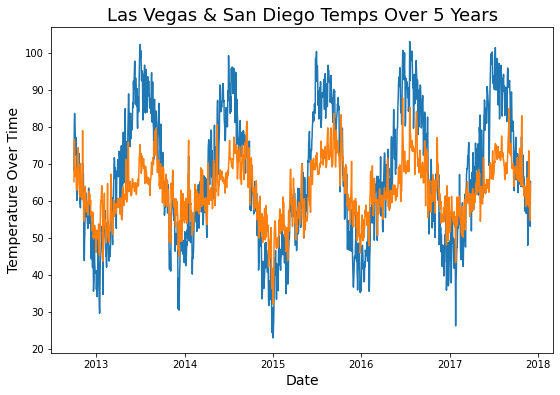

In [473]:
##apply rolling averages first and then select two cities to plot

temps_LV_SD_df = temperatureF_df[["Date", "Time","Las Vegas", "San Diego"]]
#print(temps_LV_SD_df.head())

# import the module and apply rolling mean
from statsmodels.tsa.arima_process import ArmaProcess

temps_LV_SD_df.rolling(7).mean()

# Time series plot with Seaborn lineplot() with label
plt.figure(figsize=(9,6))
sns.lineplot(x="Date",y="Las Vegas",
             data=temps_LV_SD_df,
             ci=None)
# 7-day rolling average Time series plot with Seaborn lineplot() with label
g=sns.lineplot(x="Date",y="San Diego",
             data=temps_LV_SD_df,
             ci=None)
g.set_title("Las Vegas & San Diego Temps Over 5 Years", size = 18)
# set axis labels
plt.xlabel("Date", size=14)
plt.ylabel("Temperature Over Time", size=14)

# save image as PNG file
plt.savefig("Las_Vegas_San_Diego.png",
                    format='png',
                    dpi=150)

## 7.	Perform SARIMA on five cities, iterating through the cities programmatically. Explain your results.

Temperature, and weather in general, are not stationary data, because the distribution over temperatures in one part of the year is not the same as the distribution over temperatures during another part of the year. In other words, the joint distribution changes when shifted in time.

In [84]:
#temperatureF_df
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as sm

cities_subset = ["Phoenix", "Seattle", "Jerusalem", "Montreal", "Boston"]

def sArImA(x):
    for x in range(len(cities_subset)):
        model = SARIMAX(temperatureF_df["Phoenix"], exog=None, order=(1,1,1), seasonal_order = (1,1,0,12), trend="c")
        model_fit = model.fit()
        print(model_fit.summary())
        break
    
#cities_subset_sarima = temperatureF_df.apply(sArImA)

    
    
res = sm.adfuller(temperatureF_df['Phoenix'].diff().dropna(),regression='ct')
print('p-value:{}'.format(res[1]))


AttributeError: module 'statsmodels.api' has no attribute 'adfuller'

In [87]:

my_order = (1,1,1)
seas_order = (1,1,0,12)
model = SARIMAX(temperatureF_df["Phoenix"], exog=None, order=my_order, seasonal_order = seas_order, trend="c")
model_fit = model.fit()
model_fit.summary()

#adfuller_Seattle = adfuller(temperatureF_df['Seattle'])
#print(adfuller_Seattle[1])


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53777D+00    |proj g|=  1.57583D-01

At iterate    5    f=  2.22426D+00    |proj g|=  6.10326D-01

At iterate   10    f=  2.21107D+00    |proj g|=  2.25053D-02

At iterate   15    f=  2.20969D+00    |proj g|=  2.81149D-01

At iterate   20    f=  2.20907D+00    |proj g|=  5.27041D-03

At iterate   25    f=  2.20422D+00    |proj g|=  3.49015D-01

At iterate   30    f=  2.20135D+00    |proj g|=  1.14570D+00


KeyboardInterrupt: 

## 7a.	Graph the predicted values 30 days out.

In [88]:
#Forecasting an AR model
# Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA




# Import the plot_acf module from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

# Plot the thing
fig, ax = plt.subplots()
ax.hist(temperatureF_df["Phoenix"])

# Plot the autocorrelation of the temps
fig = plot_acf(temperatureF_df["Phoenix"])

# Label axes
ax.set_title("Temps in Phoenix")

plt.show()

ModuleNotFoundError: No module named 'auto_ts'

## 8.	Explain what you see when you perform results.summary() on the cities in question 7. 

## Bonus:
What do GARCH and ARCH Stand for? Break down and explain each piece in the names. Explain the difference between the two. Create a GARCH and ARCH model on the same 5 cities from question 6. Explain and graph the results.


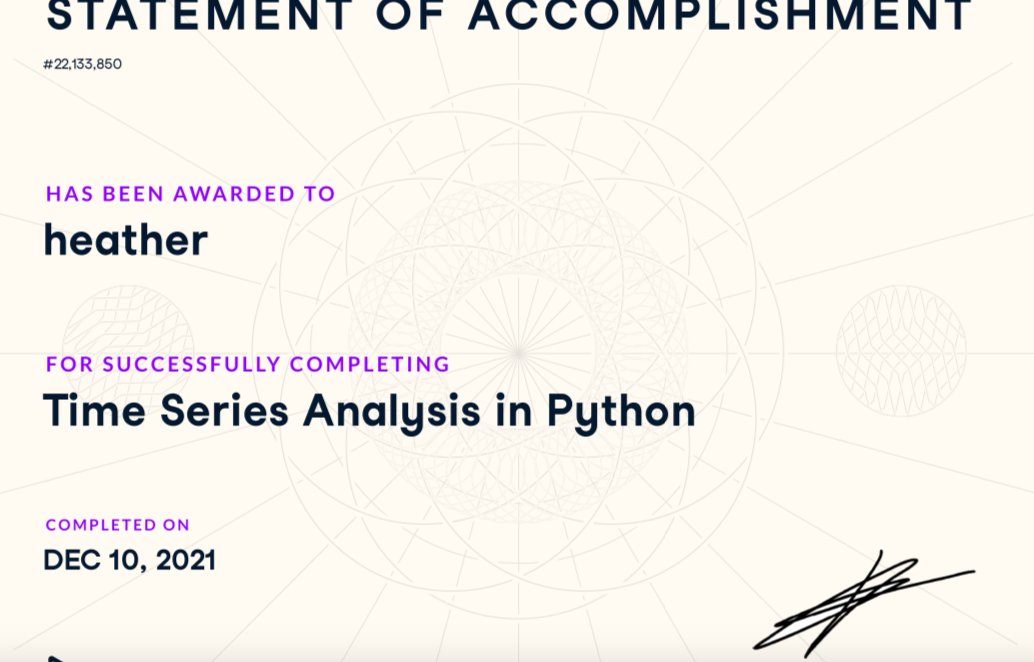